# cmip Events

Get the indeces from traditional and EC calcs and determine events

In [1]:
import xarray
import numpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches


In [2]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.sstIndex as sst
import utils.pslIndex as psl
import utils.timePeriod as tp
import utils.compound as compound
import utils.ecIndex as ec
import utils.overlapBins as overlapBins


# Find events in the e and c indeces

 1 sigma above/below mean
Using a piControl climatology

In [3]:
ecXr=xarray.open_dataset('results/cmip6EcIndex.nc').sel(model=_model.scenarioMip[:,1])

piControlEcXr=ecXr.sel(experiment='piControl', drop=True)


# This should calculate stds for all experiments and all indeces
stdEcXr = piControlEcXr.std(dim='year')
stdEcXr

<xarray.Dataset>
Dimensions:  (model: 35)
Coordinates:
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    eIndex   (model) float64 0.6339 0.8717 0.6902 0.6543 ... 0.7986 0.75 0.7068
    cIndex   (model) float64 0.962 0.8771 0.8874 0.8806 ... 0.841 0.8212 0.8975

Apply the 1 sigma criteria

In [4]:
firePosEc, fireNegEc = compound.applyCriteria(ecXr, stdEcXr)

firePos: 
['cIndex', 'eIndex']
fireNeg: 
[]


In [5]:
# find where either index is saying there is an event
# this is a bit messy, you need to make sure Nan years stay as Nan (years for the piControl is different for all the models)

firePosEc['ecCombined']=(((firePosEc.cIndex+firePosEc.eIndex)>0)*1).where(
        firePosEc.cIndex.isnull()==False)
fireNegEc['ecCombined']=(((fireNegEc.cIndex+fireNegEc.eIndex)>0)*1).where(
    fireNegEc.cIndex.isnull()==False)


In [6]:
#Find events in the trad indeces

In [7]:
tradIndecesXr = xarray.concat([
    xarray.open_dataset('results/cmip6'+experiment+'TradIndecesTos.nc') for experiment in ['piControl','ssp585']], 
'experiment')

tradIndecesXr['experiment']=['piControl','ssp585']



In [8]:
piControlXr=tradIndecesXr.sel(experiment='piControl',drop=True)

piControlXr.model.values

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2', 'CESM2-WACCM', 'CIESM',
       'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-ESM2-1',
       'CanESM5', 'CanESM5-CanOE', 'EC-Earth3', 'EC-Earth3-CC',
       'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'GFDL-CM4', 'GFDL-ESM4',
       'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8', 'INM-CM5-0',
       'IPSL-CM6A-LR', 'MCM-UA-1-0', 'MIROC-ES2L', 'MIROC6',
       'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM',
       'NorESM2-MM', 'UKESM1-0-LL'], dtype=object)

In [9]:
stdXr = piControlXr.std(dim='year')

criteriaXr= xarray.merge(
    (stdXr[['nino3','nino34','nino4','dmi','eastIO']],
     stdXr[['samWinter','samSummer']]/2)
)

In [10]:
firePosTrad, fireNegTrad = compound.applyCriteria(tradIndecesXr, criteriaXr)


firePos: 
['nino4', 'samWinter', 'dmi', 'nino3', 'nino34']
fireNeg: 
['samSummer', 'eastIO']


Now we can merge the events from each method

In [11]:
firePos=xarray.merge([firePosEc,firePosTrad])
fireNeg=xarray.merge([fireNegEc,fireNegTrad])

In [12]:
fireXr=xarray.concat([firePos,fireNeg], 'fire')
fireXr['fire']=['pos','neg']

fireXr.to_netcdf('results/cmipEcEvents.nc')


# an attempt at a summary plot

In [13]:
fireXr=xarray.open_dataset('results/cmipEcEvents.nc')

In [17]:
summaryXr=fireXr[['ecCombined','dmi','samWinter','samSummer']].sel(experiment='ssp585', year=slice(1850,2099),drop=True)

In [20]:
nEventsCurrentXr=summaryXr.sel(year=slice(1950,1999),drop=True).sum('year')
nEventsFutureXr=summaryXr.sel(year=slice(2050,2099),drop=True).sum('year')


In [243]:
import scipy.stats as stats

In [249]:
for iIndex in ['ecCombined','dmi','samWinter','samSummer']:
    print(iIndex)
    for iFire in ['pos','neg']:
        print(iFire)
        print(stats.kstest(
            nEventsCurrentXr[iIndex].sel(fire=iFire,drop=True),
            nEventsFutureXr[iIndex].sel(fire=iFire,drop=True)
        ))

ecCombined
pos
KstestResult(statistic=0.7428571428571429, pvalue=1.1593847273599567e-09)
neg
KstestResult(statistic=0.42857142857142855, pvalue=0.002885996519380205)
dmi
pos
KstestResult(statistic=0.8285714285714286, pvalue=2.3374692083870097e-12)
neg
KstestResult(statistic=0.6, pvalue=3.4452298564531986e-06)
samWinter
pos
KstestResult(statistic=0.9714285714285714, pvalue=1.2479244585402055e-18)
neg
KstestResult(statistic=0.9714285714285714, pvalue=1.2479244585402055e-18)
samSummer
pos
KstestResult(statistic=0.9428571428571428, pvalue=4.305339381963709e-17)
neg
KstestResult(statistic=0.9714285714285714, pvalue=1.2479244585402055e-18)


In [122]:
import os
os.environ["CARTOPY_USER_BACKGROUNDS"] = "/home/603/as2285/compound-new/ref/"

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/PIL/Image.py:2855: DecompressionBombWarning: Image size (131220000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


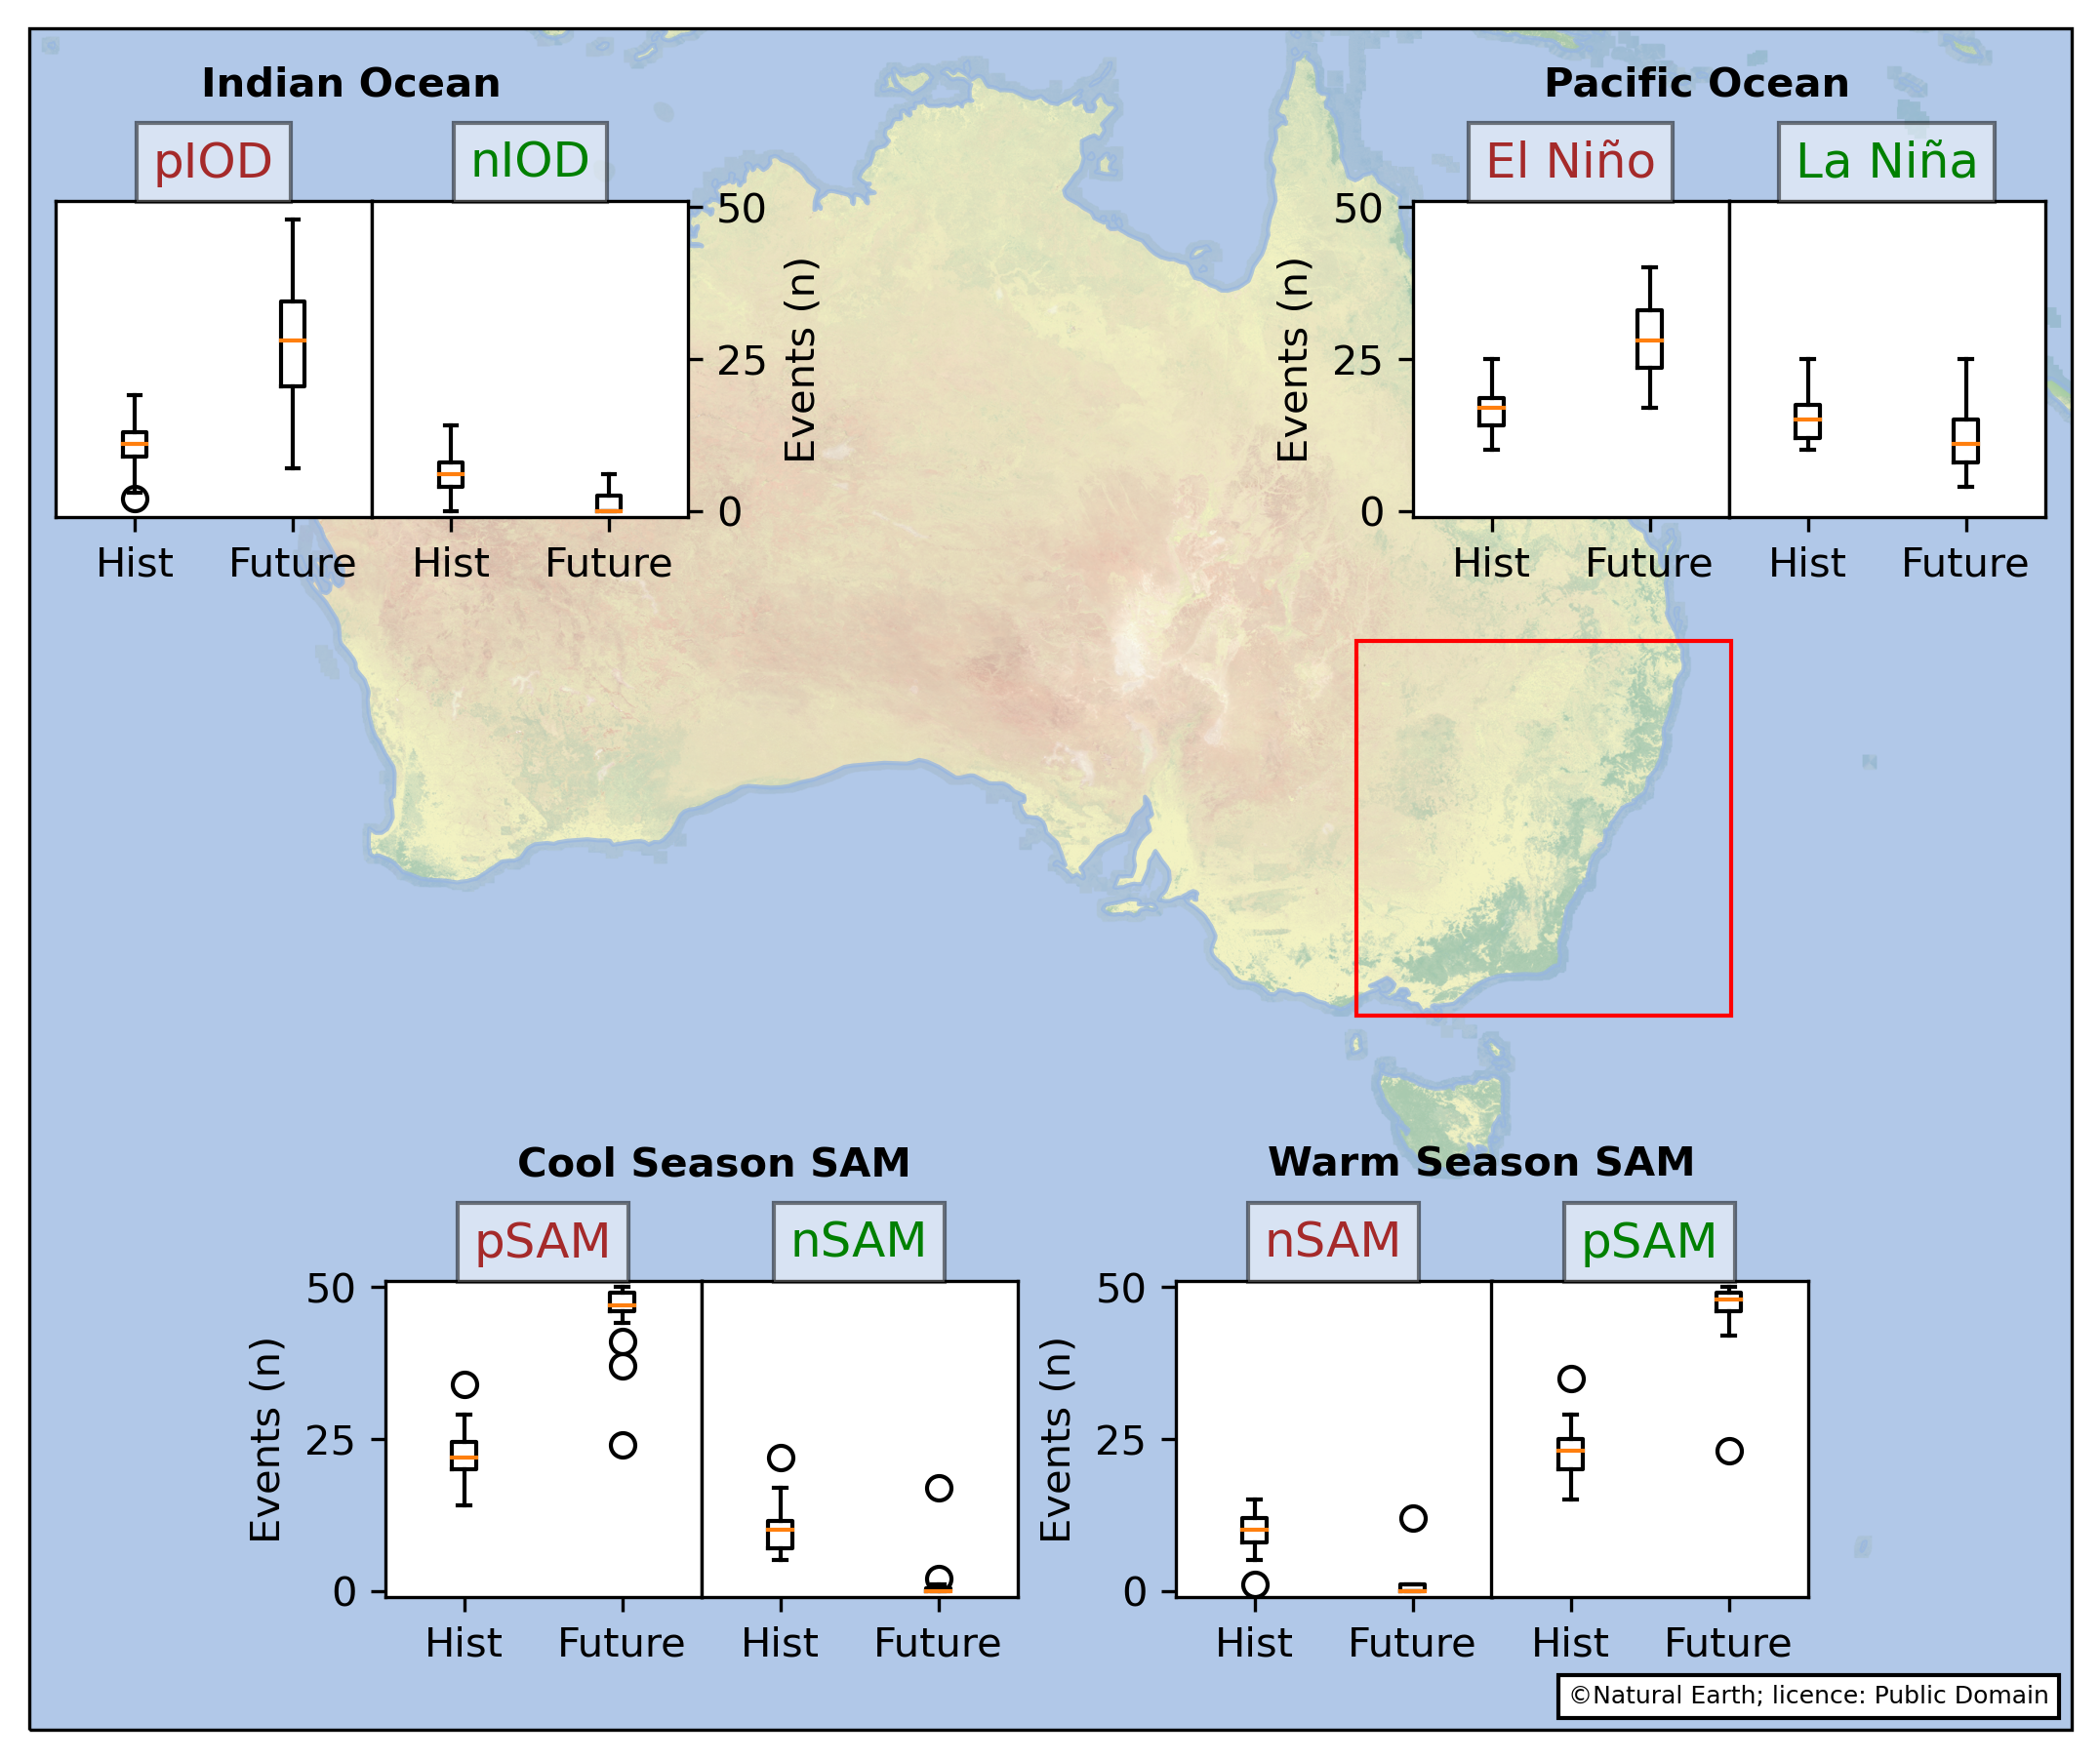

In [240]:
from matplotlib.offsetbox import AnchoredText

fig=plt.figure(figsize=(9,9), dpi=300)

ax=fig.add_subplot(projection=ccrs.PlateCarree())

ax.background_img(name="NE1", resolution="low")

ax.set_xlim(105,165)
ax.set_ylim(-60,-10)

#credit: https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
ax.add_feature(cfeature.OCEAN, zorder=0.5, alpha =0.75) 

#are of interest
ax.add_patch(mpatches.Rectangle(xy=[144, -39], width=11, height=11,
                                edgecolor='red',facecolor='none' ))

# Add a text annotation for the license information to the bottom right corner.
text = AnchoredText(u"\u00A9" + "Natural Earth; licence: Public Domain",
                        loc='lower right', prop={'size': 6}, frameon=True)
ax.add_artist(text)

axW=0.12
axH=0.12
axL=0.26
axBot=0.23
axTop=0.64

for iIndex in (
    ['ecCombined','El Niño', 'La Niña',[0.65,axTop,axW,axH],[0.65+axW,axTop,axW,axH] ],
    ['dmi', 'pIOD','nIOD',[0.135,axTop,axW,axH],[0.135+axW,axTop,axW,axH] ],
    ['samWinter','pSAM','nSAM',[axL,axBot,axW,axH],[axL+axW,axBot,axW,axH] ],
    ['samSummer','nSAM','pSAM',[axL+2.5*axW,axBot,axW,axH],[axL+3.5*axW,axBot,axW,axH] ]
):
    #plt.figure(figsize=(4,2))
    
    ax0=plt.axes(iIndex[3])
    
    #ax0=plt.subplot(1,2,1)

    plt.boxplot([
        nEventsCurrentXr[iIndex[0]].sel(fire='pos',drop=True),
        nEventsFutureXr[iIndex[0]].sel(fire='pos',drop=True)
    ])

    plt.xticks(ticks=[1,2],labels=['Hist','Future'])
    
    ax0.set_yticks(ticks=[0,25,50])
    #ax0.set_yticklabels(labels=[0,50,100])
    if iIndex[0]!='dmi':
        plt.ylabel('Events (n)')
    t=plt.title(iIndex[1], color='brown')
    t.set_bbox(dict(facecolor='white', alpha=0.5))
    ax1=plt.axes(iIndex[4],sharey=ax0)

    plt.boxplot([
        nEventsCurrentXr[iIndex[0]].sel(fire='neg',drop=True),
        nEventsFutureXr[iIndex[0]].sel(fire='neg',drop=True)
    ])
    ax1.axes.yaxis.set_visible(False)
    plt.xticks(ticks=[1,2],labels=['Hist','Future'])
    plt.ylim([-1,51])
    t=plt.title(iIndex[2],color='green')
    t.set_bbox(dict(facecolor='white', alpha=0.5))
    if iIndex[0]=='dmi':
        plt.ylabel('Events (n)')
        ax0.axes.yaxis.set_visible(False)
        ax1.axes.yaxis.set_visible(True)
        ax1.yaxis.set_label_position("right")
        ax1.yaxis.tick_right()
    
_ =plt.figtext(0.19, 0.8, 'Indian Ocean', weight='bold')
_ = plt.figtext(0.70, 0.8, 'Pacific Ocean', weight='bold')
_ = plt.figtext(0.31, 0.39, 'Cool Season SAM', #color='red',
            weight='bold')
_ = plt.figtext(0.595, 0.39, 'Warm Season SAM', #color='blue', 
            weight='bold')

plt.savefig('figures/summaryMap.pdf', bbox_inches='tight')


# Put the resutls in 30 year bins

In [13]:
fireXr=xarray.open_dataset('results/cmipEcEvents.nc')

In [14]:
#ssp585
fireBinnedXr=overlapBins.binSum(fireXr.sel(experiment='ssp585', year=slice(1850,2100),drop=True))


In [15]:
fireBinnedXr

<xarray.Dataset>
Dimensions:     (year: 23, fire: 2, model: 35)
Coordinates:
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * fire        (fire) object 'pos' 'neg'
  * year        (year) int64 1865 1875 1885 1895 1905 ... 2055 2065 2075 2085
Data variables:
    eIndex      (year, fire, model) float64 3.0 7.0 6.0 4.0 ... 1.0 1.0 0.0 0.0
    cIndex      (year, fire, model) float64 6.0 2.0 7.0 5.0 ... 13.0 10.0 6.0
    ecCombined  (year, fire, model) float64 7.0 8.0 10.0 9.0 ... 13.0 10.0 6.0
    nino4       (year, fire, model) float64 5.0 2.0 5.0 6.0 ... 3.0 7.0 7.0 2.0
    dmi         (year, fire, model) float64 7.0 2.0 4.0 5.0 ... 2.0 0.0 0.0 0.0
    nino34      (year, fire, model) float64 6.0 2.0 4.0 4.0 ... 2.0 9.0 10.0 2.0
    samWinter   (year, fire, model) float64 5.0 11.0 12.0 13.0 ... 0.0 0.0 0.0
    nino3       (year, fire, model) float64 5.0 3.0 5.0 5.0 ... 2.0 7.0 5.0 1.0
    samSummer   (year, fire, model) float64 14.0 6.0 11.0 ... 29.0 30.0 30.0
    eastIO      (year, fire, model) float64 7.0 4.0 4.0 4.0 ... 3.0 4.0 3.0 0.0
Attributes:
    Bins:     Overlapping 30 year bins, seperating by 10 year intervals
    Year:     Midpoint of bin

In [16]:
# and for piControl
binSumLs = list()

#using bin sum is a bit funky because the models have different start and end years
#run binSum for each model seperately, after filtering the nans
for iModel in _model.scenarioMip[:,1]:
    try:
        piCModelXr=fireXr.sel(experiment='piControl', drop=True).sel(model=iModel)
        binSumXr=overlapBins.binSum(piCModelXr.where(piCModelXr.isnull()==False, drop=True))
        binSumLs.append(binSumXr)
        
    except Exception as e:
        print(e)
        
piControlBinnedXr = xarray.concat(binSumLs, 'model')

In [17]:
piControlBinnedXr

<xarray.Dataset>
Dimensions:     (year: 774, model: 35, fire: 2)
Coordinates:
  * year        (year) int64 16 26 36 46 56 66 ... 6126 6136 6146 6156 6166 6176
  * model       (model) <U16 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * fire        (fire) object 'pos' 'neg'
Data variables:
    eIndex      (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    cIndex      (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    ecCombined  (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    nino4       (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    dmi         (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    nino34      (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    samWinter   (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    nino3       (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    samSummer   (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    eastIO      (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Bins:     Overlapping 30 year bins, seperating by 10 year intervals
    Year:     Midpoint of bin

In [18]:
firePosBinnedXr=fireBinnedXr.sel(fire='pos', drop=True)
piControlPosBinnedXr=piControlBinnedXr.sel(fire='pos', drop=True)

fireNegBinnedXr=fireBinnedXr.sel(fire='neg', drop=True)
piControlNegBinnedXr=piControlBinnedXr.sel(fire='neg', drop=True)

# Index Comparisons - ENSO

In [19]:
%run utils/emergence.ipynb

Text(0, 0.5, 'index')

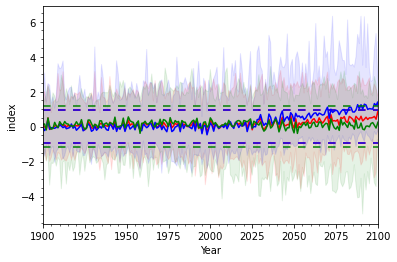

In [20]:
overlaidEmergePlot(
    xarray.merge([
        tradIndecesXr.sel(experiment='ssp585',drop=True).nino34,
        ecXr.sel(experiment='ssp585',drop=True)
    ]), 
    xarray.merge([
        tradIndecesXr.sel(experiment='piControl',drop=True).nino34,
        ecXr.sel(experiment='piControl',drop=True)
    ])
)

plt.xlim([1900,2100])
plt.ylabel('index')

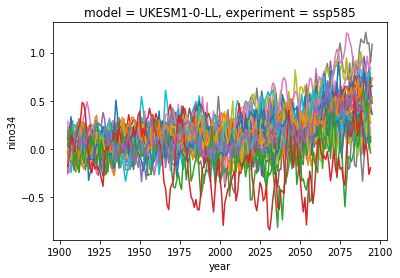

In [21]:
for iModel in tradIndecesXr.model.values:
    tradIndecesXr.sel(
        model=iModel, experiment='ssp585', year=slice(1900,2100)
    ).nino34.rolling(year=11,center=True).mean('year').plot()


Text(0, 0.5, 'index')

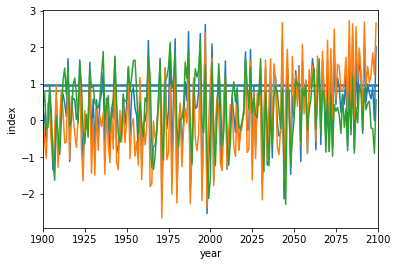

In [22]:
tradIndecesXr.sel(experiment='ssp585',model='CESM2',drop=True).nino34.plot()
ecXr.sel(experiment='ssp585',model='CESM2',drop=True).eIndex.plot()
ecXr.sel(experiment='ssp585',model='CESM2',drop=True).cIndex.plot()

plt.hlines(
    [
        stdEcXr.eIndex.sel(model='CESM2'),
        stdEcXr.cIndex.sel(model='CESM2'),
        stdXr.nino34.sel(model='CESM2')
    ],
    1900,2100
)

plt.xlim([1900,2100])
plt.ylabel('index')

# Index Comparisons - IOD

In [23]:
firePosBinnedXr

<xarray.Dataset>
Dimensions:     (year: 23, model: 35)
Coordinates:
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * year        (year) int64 1865 1875 1885 1895 1905 ... 2055 2065 2075 2085
Data variables:
    eIndex      (year, model) float64 3.0 7.0 6.0 4.0 3.0 ... 8.0 12.0 15.0 19.0
    cIndex      (year, model) float64 6.0 2.0 7.0 5.0 4.0 ... 14.0 1.0 5.0 7.0
    ecCombined  (year, model) float64 7.0 8.0 10.0 9.0 ... 16.0 13.0 16.0 19.0
    nino4       (year, model) float64 5.0 2.0 5.0 6.0 ... 16.0 12.0 10.0 13.0
    dmi         (year, model) float64 7.0 2.0 4.0 5.0 6.0 ... 4.0 18.0 21.0 22.0
    nino34      (year, model) float64 6.0 2.0 4.0 4.0 4.0 ... 12.0 10.0 9.0 11.0
    samWinter   (year, model) float64 5.0 11.0 12.0 13.0 ... 28.0 29.0 29.0 30.0
    nino3       (year, model) float64 5.0 3.0 5.0 5.0 ... 10.0 11.0 10.0 14.0
    samSummer   (year, model) float64 14.0 6.0 11.0 10.0 ... 0.0 0.0 0.0 0.0
    eastIO      (year, model) float64 7.0 4.0 4.0 4.0 6.0 ... 2.0 19.0 20.0 22.0
Attributes:
    Bins:     Overlapping 30 year bins, seperating by 10 year intervals
    Year:     Midpoint of bin

(1900.0, 2085.0)

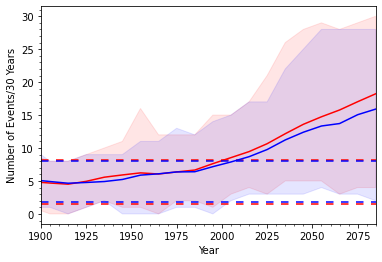

In [24]:
overlaidEmergePlot(
    firePosBinnedXr[['dmi','eastIO']],
    piControlPosBinnedXr[['dmi','eastIO']]
      )

plt.xlim([1900,2085])


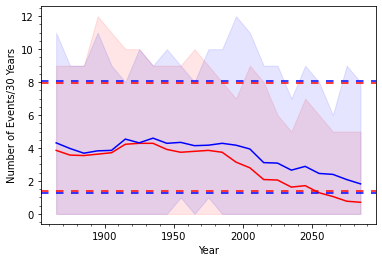

In [25]:
overlaidEmergePlot(
    fireNegBinnedXr[['dmi','eastIO']],
    piControlNegBinnedXr[['dmi','eastIO']]
      )
plt.show()

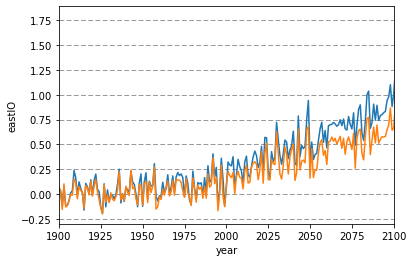

In [26]:
tradIndecesXr.sel(experiment='ssp585',drop=True).dmi.mean('model').plot()
(tradIndecesXr.sel(experiment='ssp585',drop=True).eastIO.mean('model')*-1).plot()
plt.xlim([1900,2100])
plt.grid(axis='y', color='grey', dashes=[6,3])


Text(0, 0.5, 'index')

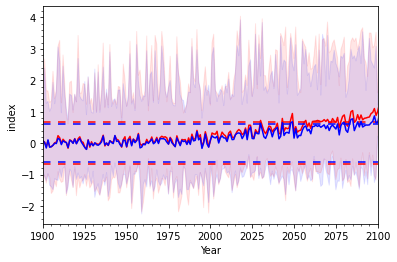

In [27]:
overlaidEmergePlot(
    xarray.merge([
        tradIndecesXr.sel(experiment='ssp585',drop=True).dmi,
        (tradIndecesXr.sel(experiment='ssp585',drop=True).eastIO*-1)
    ]), 
    xarray.merge([
        tradIndecesXr.sel(experiment='piControl',drop=True).dmi,
        (tradIndecesXr.sel(experiment='piControl',drop=True).eastIO*-1)
    ])
)

plt.xlim([1900,2100])
plt.ylabel('index')

# How do they look when compounded?

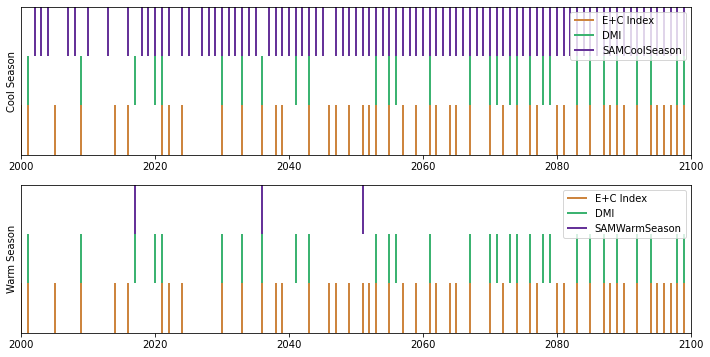

In [28]:
plt.figure(figsize=(12,6))

colors = ['peru', 'mediumseagreen', 'rebeccapurple']
indeces = ['ecCombined','dmi','samWinter']

toPlot=fireXr.sel(
    fire='pos',
    experiment='ssp585',
    year=slice(1900,2099),
    model='CESM2',
    drop=True
)

plt.subplot(2,1,1)

iPlot=0
for iIndex in indeces:
    plt.vlines(
        x=toPlot[iIndex].where(toPlot[iIndex],drop=True).year, 
        ymin=iPlot,
        ymax=(iPlot+1),#*(toPlot[iIndex].where(toPlot[iIndex])),
        color=colors[iPlot], 
        linewidth=2
    )
    iPlot=iPlot+1
plt.legend(['E+C Index','DMI','SAMCoolSeason'])
plt.xlim(2000,2100)
plt.ylim([0,3])
plt.yticks([])
plt.ylabel('Cool Season')


plt.subplot(2,1,2)

indeces = ['ecCombined','dmi','samSummer']


iPlot=0
for iIndex in indeces:
    plt.vlines(
        x=toPlot[iIndex].where(toPlot[iIndex],drop=True).year, 
        ymin=iPlot,
        ymax=(iPlot+1),#*(toPlot[iIndex].where(toPlot[iIndex])),
        color=colors[iPlot], 
        linewidth=2
    )
    iPlot=iPlot+1
plt.legend(['E+C Index','DMI','SAMWarmSeason'])
plt.xlim(2000,2100)
plt.ylim([0,3])
plt.yticks([])
plt.ylabel('Warm Season')

plt.savefig('figures/cmip6compoundExampleDry.pdf',bbox_inches='tight')

# Calculate the compounding years

In [29]:
allCompoundsXr=xarray.concat([
    compound.compound(firePos),
    compound.compound(fireNeg)],
    'fire')

allCompoundsXr['fire']=['pos','neg']



nino4EastioSamsummer
nino4EastioSamwinter
nino4DmiSamsummer
nino4DmiSamwinter
eIndexEastioSamsummer
eIndexEastioSamwinter
eIndexDmiSamsummer
eIndexDmiSamwinter
ecCombinedEastioSamsummer
ecCombinedEastioSamwinter
ecCombinedDmiSamsummer
ecCombinedDmiSamwinter
nino34EastioSamsummer
nino34EastioSamwinter
nino34DmiSamsummer
nino34DmiSamwinter
nino3EastioSamsummer
nino3EastioSamwinter
nino3DmiSamsummer
nino3DmiSamwinter
cIndexEastioSamsummer
cIndexEastioSamwinter
cIndexDmiSamsummer
cIndexDmiSamwinter
nino4EastioSamsummer
nino4EastioSamwinter
nino4DmiSamsummer
nino4DmiSamwinter
eIndexEastioSamsummer
eIndexEastioSamwinter
eIndexDmiSamsummer
eIndexDmiSamwinter
ecCombinedEastioSamsummer
ecCombinedEastioSamwinter
ecCombinedDmiSamsummer
ecCombinedDmiSamwinter
nino34EastioSamsummer
nino34EastioSamwinter
nino34DmiSamsummer
nino34DmiSamwinter
nino3EastioSamsummer
nino3EastioSamwinter
nino3DmiSamsummer
nino3DmiSamwinter
cIndexEastioSamsummer
cIndexEastioSamwinter
cIndexDmiSamsummer
cIndexDmiSamwinter


That is a bit of a crazy long list, so well be a little bit selective

In [30]:
compoundNames= [
    #'nino4EastioSamwinter',
    #'nino4EastioSamsummer',
    #'nino4DmiSamwinter',
    #'nino4DmiSamsummer',
    'nino34EastioSamwinter',
    'nino34EastioSamsummer',
    'nino34DmiSamwinter',
    'nino34DmiSamsummer',
    'cIndexEastioSamwinter',
    'cIndexEastioSamsummer',
    'cIndexDmiSamwinter',
    'cIndexDmiSamsummer',
    'eIndexEastioSamwinter',
    'eIndexEastioSamsummer',
    'eIndexDmiSamwinter',
    'eIndexDmiSamsummer',
    'ecCombinedEastioSamwinter',
    'ecCombinedEastioSamsummer',
    'ecCombinedDmiSamwinter',
    'ecCombinedDmiSamsummer'
]

In [31]:
allCompoundsXr[compoundNames].to_netcdf('results/cmip6Compounds.nc') 

In [32]:
#example
allCompoundsXr.sel(compound='all3',fire='pos',experiment='ssp585',year=slice(1950,2000),drop=True)

<xarray.Dataset>
Dimensions:                    (year: 51, model: 35)
Coordinates:
  * year                       (year) int64 1950 1951 1952 ... 1998 1999 2000
  * model                      (model) object 'ACCESS-CM2' ... 'UKESM1-0-LL'
Data variables: (12/24)
    nino4EastioSamsummer       (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nino4EastioSamwinter       (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nino4DmiSamsummer          (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nino4DmiSamwinter          (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    eIndexEastioSamsummer      (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    eIndexEastioSamwinter      (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                         ...
    nino3DmiSamsummer          (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nino3DmiSamwinter          (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cIndexEastioSamsummer      (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cIndexEastioSamwinter      (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cIndexDmiSamsummer         (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cIndexDmiSamwinter         (model, year) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    indexNames:  ['nino4', 'eastIO', 'samSummer']
    indeces:     ['enso', 'iod', 'sam']
    pairs:       ['enso+iod', 'enso+sam', 'iod+sam']
    others:      ['all3', 'anyCompound', 'nEvents']